## FORMULA 1 PROJECT- Generate Predictions

In [54]:
%run F1_classes_func.ipynb

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_1 = pd.read_csv(directory + 'dataset.csv')
dataset_2 = pd.read_csv(directory + 'dataset_2.csv')
dataset_3 = pd.read_csv(directory + 'dataset_3.csv')

test_1 = dataset_1[dataset_1['year'] == 2017]
test_2 = dataset_2[dataset_2['year'] == 2017]
test_3 = dataset_3[dataset_3['year'] == 2017]

In [4]:
# Ensure all classifiers use the same random state
rs=12

clfs = [
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight=None)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Logistic Regression', LogisticRegression(random_state = rs)],
    ['KNN', KNeighborsClassifier()],
    ['SVC', SVC(random_state=rs, probability=True)],
    ['LDA', LinearDiscriminantAnalysis()],
    ['MLP', MLPClassifier(random_state=rs)],
]

meta_learner_GB = ['Gradient Boosting', GradientBoostingClassifier(random_state=rs, learning_rate=0.01, n_estimators=1000)]

## 1) First-Level Predictions (Without hyperparameter tuning)

#### Definitions:
- Model: Different methods of Train-test split defines a model. Each model is suffixed with the dataset name, followed by the number of races included the train set (excluding the race of the same name in the previous seasons). 
- Sub-model: Within the model, predictions are generated for each selected classifier. Each classifier counts as one sub-model

#### Goal: To find the 'best' model that gives the highest AUC score averaged across all races in a season (either with or without ensemble stacking).

#### These are the following models to run:
- MODEL 1_3 -> Dataset 1, Train:2016, qty_races_tofilter=3
- MODEL 1_4 -> Dataset 1, Train:2016, qty_races_tofilter=4
- MODEL 1_5 -> Dataset 1, Train:2016, qty_races_tofilter=5
- MODEL 2_3 -> Dataset 2, Train:2016, qty_races_tofilter=3
- MODEL 2_4 -> Dataset 2, Train:2016, qty_races_tofilter=4
- MODEL 2_5 -> Dataset 2, Train:2016, qty_races_tofilter=5
- MODEL 3_3 -> Dataset 3, Train:2016, qty_races_tofilter=3
- MODEL 3_4 -> Dataset 3, Train:2016, qty_races_tofilter=4
- MODEL 3_5 -> Dataset 3, Train:2016, qty_races_tofilter=5

In [55]:
dfs = [dataset_1, dataset_2, dataset_3]
dfs_test = [test_1, test_2, test_3]
CR = ClassifyRaces(dfs, dfs_test, clfs)

In [6]:
all_models_report, submodel_report, Pa_train_all, Pa_test_all, cv_results_all, results_all = \
    CR.run_models(actual=False, metric='AUC Score', qtys=[3,4,5], train_yr=[2016], test_yr=[2017],
                  model_names=['1_3', '1_4', '1_5', '2_3', '2_4', '2_5', '3_3', '3_4', '3_5'], 
                  fsel_list=False)

## Evaluate models

#### a) Find the best perfoming model in terms of highest AUC Score

In [7]:
all_models_report

,Average AUC score,Average Avg Precision,Average Dist from baseline,Average F1 score,Extra Trees,Gradient Boosting,KNN,LDA,List of races: Test acc > Baseline acc,Logistic Regression,MLP,No. of races: Test acc > Baseline acc,Random Forest,SVC
1_3,0.528682,0.776831,-0.034375,0.827171,3,4,4.0,4.0,"[Bahrain Grand Prix, Russian Grand Prix, Monac...",5,4,8,2,1.0
1_4,0.523004,0.774577,-0.040000,0.822568,3,4,1.0,2.0,"[Chinese Grand Prix, Bahrain Grand Prix, Monac...",5,5,8,4,1.0
1_5,0.516669,0.771940,-0.040937,0.825137,4,5,3.0,5.0,"[Chinese Grand Prix, Bahrain Grand Prix, Russi...",4,4,11,4,NaN
2_3,0.511874,0.770004,-0.042813,0.820807,3,4,NaN,2.0,"[Australian Grand Prix, Chinese Grand Prix, Ba...",5,3,10,3,NaN
2_4,0.511243,0.769190,-0.045625,0.817918,4,5,1.0,2.0,"[Chinese Grand Prix, Bahrain Grand Prix, Monac...",4,3,10,2,1.0
2_5,0.511474,0.768686,-0.044375,0.824053,1,6,2.0,NaN,"[Australian Grand Prix, Chinese Grand Prix, Ba...",1,3,11,4,NaN
3_3,0.518732,0.772112,-0.042813,0.819925,5,3,2.0,1.0,"[Australian Grand Prix, Chinese Grand Prix, Ba...",4,3,11,4,NaN
3_4,0.511995,0.770150,-0.043438,0.823672,2,2,1.0,3.0,"[Australian Grand Prix, Chinese Grand Prix, Ba...",4,3,6,3,NaN
3_5,0.512699,0.769817,-0.040000,0.828431,4,1,2.0,4.0,"[Australian Grand Prix, Chinese Grand Prix, Ba...",4,4,8,1,NaN


#### b) Find the best perfoming sub-model in terms of highest AUC Score

In [8]:
submodel_report.head(20)

,Model,Method,AUC Score
0,1_4,Gradient Boosting,0.554184
1,1_3,Gradient Boosting,0.553948
2,2_5,Gradient Boosting,0.548082
3,1_4,MLP,0.543481
4,3_3,Gradient Boosting,0.542270
5,3_3,Random Forest,0.539756
6,1_5,Gradient Boosting,0.539696
7,3_5,LDA,0.539361
8,2_5,Random Forest,0.537284
9,1_3,Random Forest,0.534634


#### c) Check correlation of first-level prediction probabilities of the TEST set amongst all sub-models 

In [10]:
# Narrow down the classifiers to analyse. Select only top 5 performing classifiers 
pd.DataFrame(submodel_report.groupby('Method')['AUC Score'].agg('mean'))\
                            .reset_index().sort_values('AUC Score',ascending=False)

,Method,AUC Score
1,Gradient Boosting,0.535967
6,Random Forest,0.528847
5,MLP,0.523471
0,Extra Trees,0.516197
3,LDA,0.513706
4,Logistic Regression,0.506536
2,KNN,0.506213
7,SVC,0.499174


In [11]:
# For easier visualization, remove the poorly performing classifiers.
svc_col = [col for col in Pa_test_all.columns if "SVC" in col]
knn_col = [col for col in Pa_test_all.columns if "KNN" in col]
logreg_col = [col for col in Pa_test_all.columns if "Logistic Regression" in col]

Pa_train_all_new = Pa_train_all.drop(svc_col+knn_col+logreg_col, axis=1)
Pa_test_all_new = Pa_test_all.drop(svc_col+knn_col+logreg_col, axis=1)

[MLENS] backend: threading


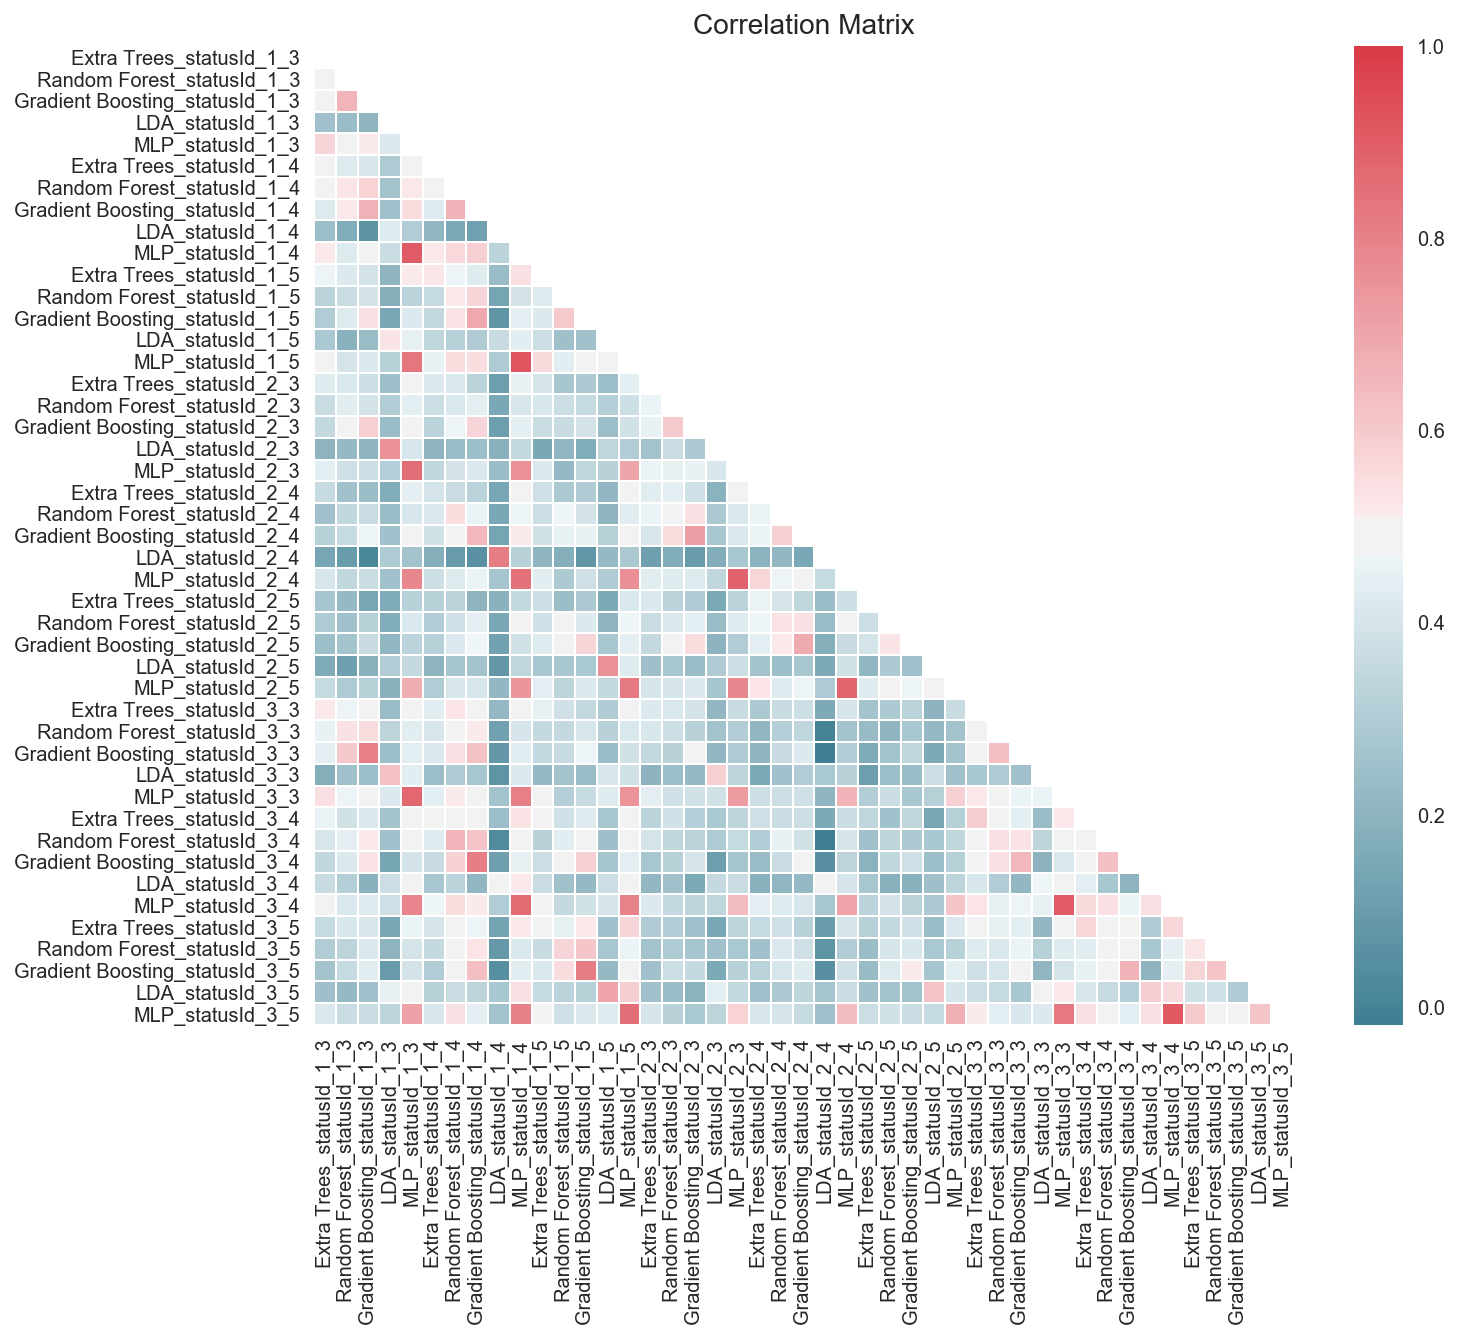

In [12]:
from mlens.visualization import corrmat

# Matrix of first level prediction results
Pa_test_all_plot = Pa_test_all_new.drop(index_list+target_var_list, axis=1)

corrmat(Pa_test_all_plot.corr(), inflate=False, annotate=False)
plt.show()

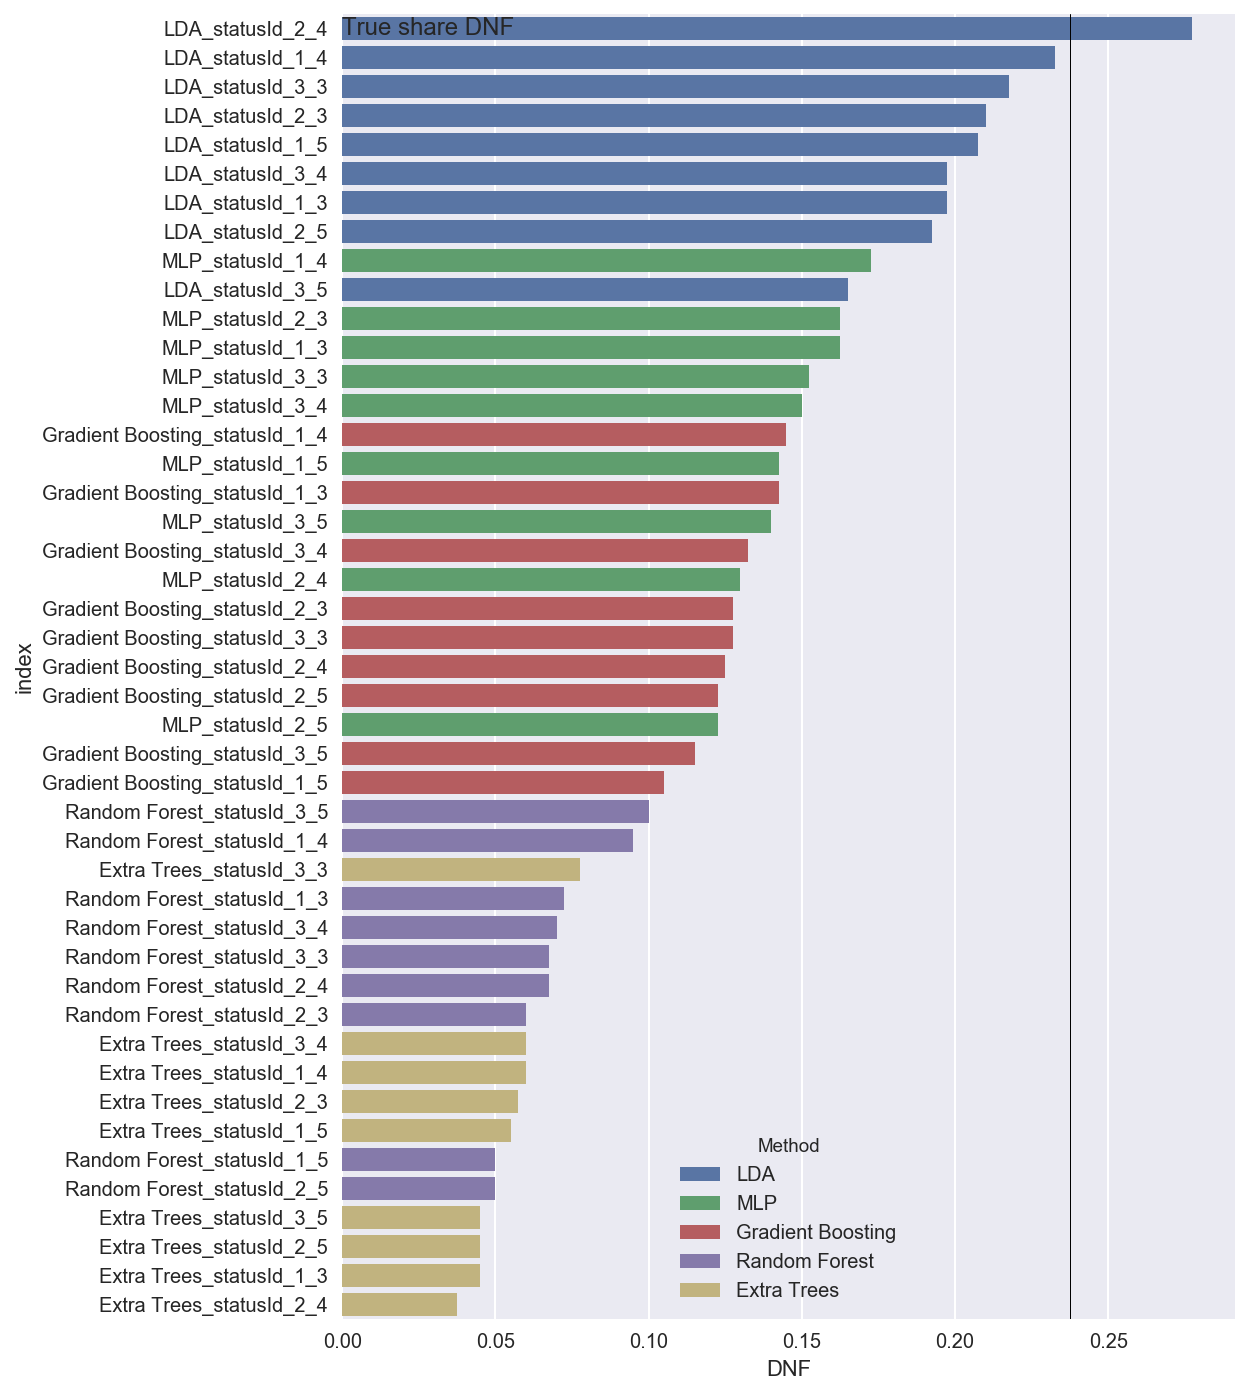

In [15]:
DNF_share = pd.Series(Pa_test_all.statusId.value_counts() / sum(Pa_test_all.statusId.value_counts()))[0]

p= Pa_test_all_plot.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True)).T.reset_index()\
            .rename(columns={True: "FIN", False:"DNF"}).sort_values('DNF', ascending=False)
p['Method'] = p['index'].apply(lambda x: x.split('_', 1)[0])

plt.figure(figsize=(8,12))
sns.set(font_scale=1)
sns.barplot(x="DNF", y="index", data=p, hue='Method', dodge=False)

plt.axvline(DNF_share, color="k", linewidth=0.5)
plt.text(0., DNF_share-0.02, "True share DNF")
plt.show()

### Detailed analysis of best perfoming model

In [16]:
best_model = results_all[(results_all['Model'] == '1_3')]

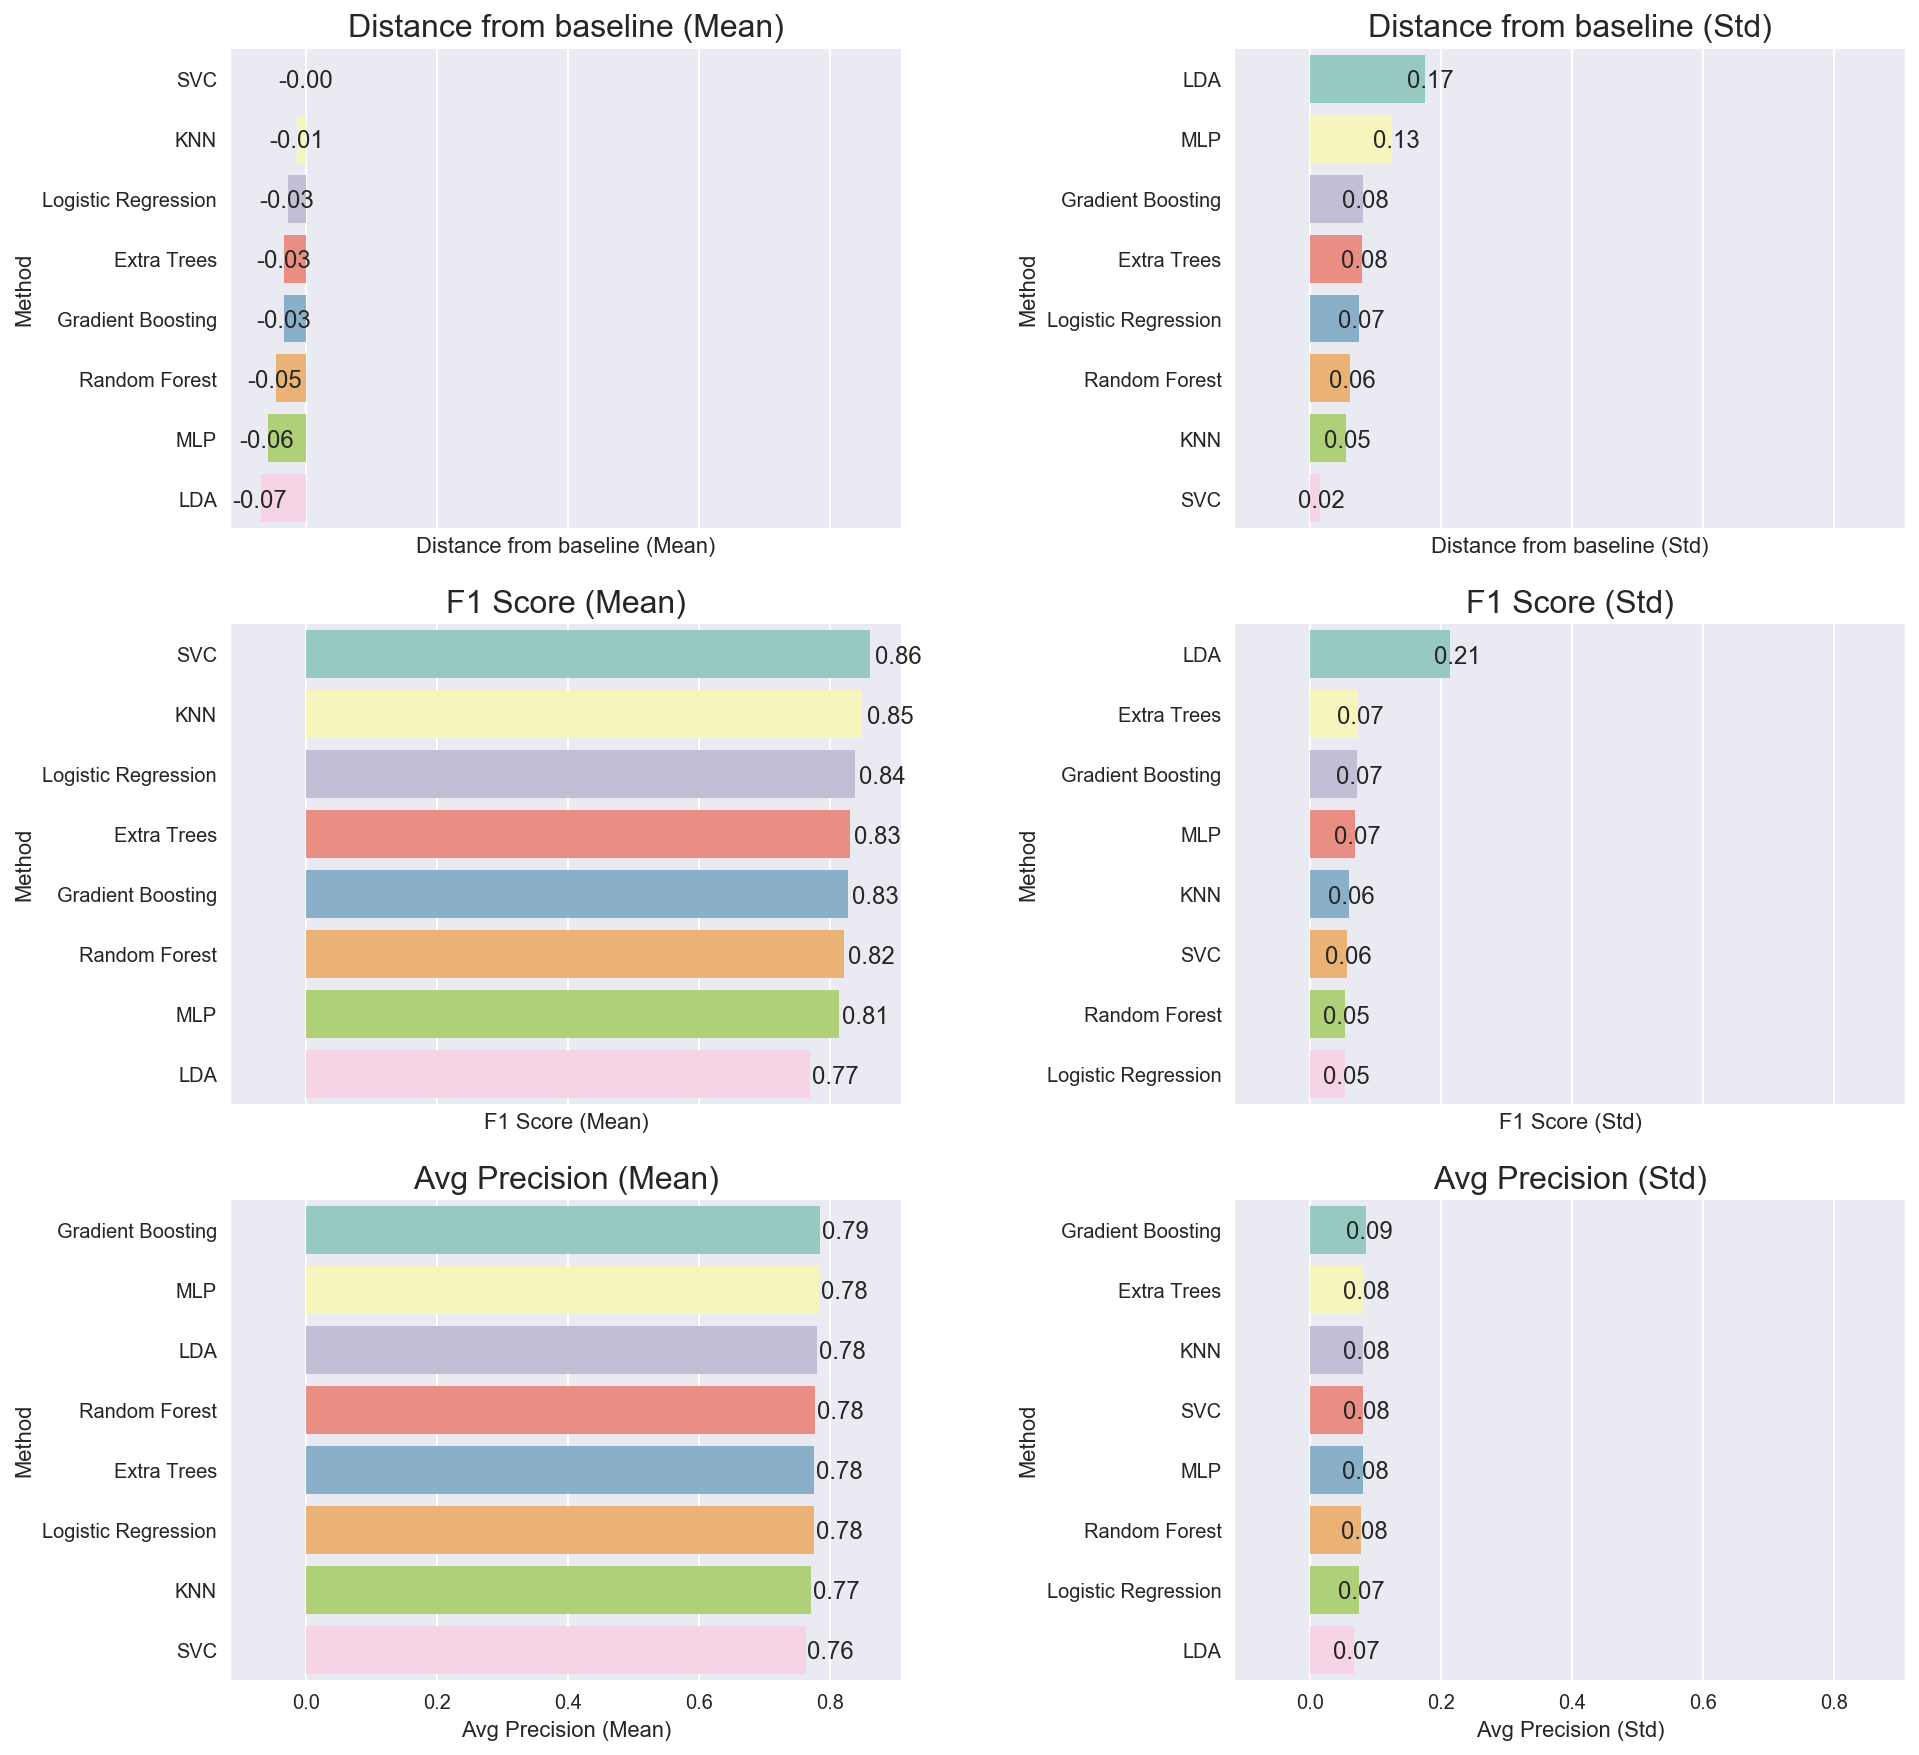

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
metrics_list = ["Distance from baseline", "F1 Score", 'Avg Precision']
plot_best_model = plot_algo_results(best_model, grp_col="Method", metrics_list=metrics_list, sort_method='desc')

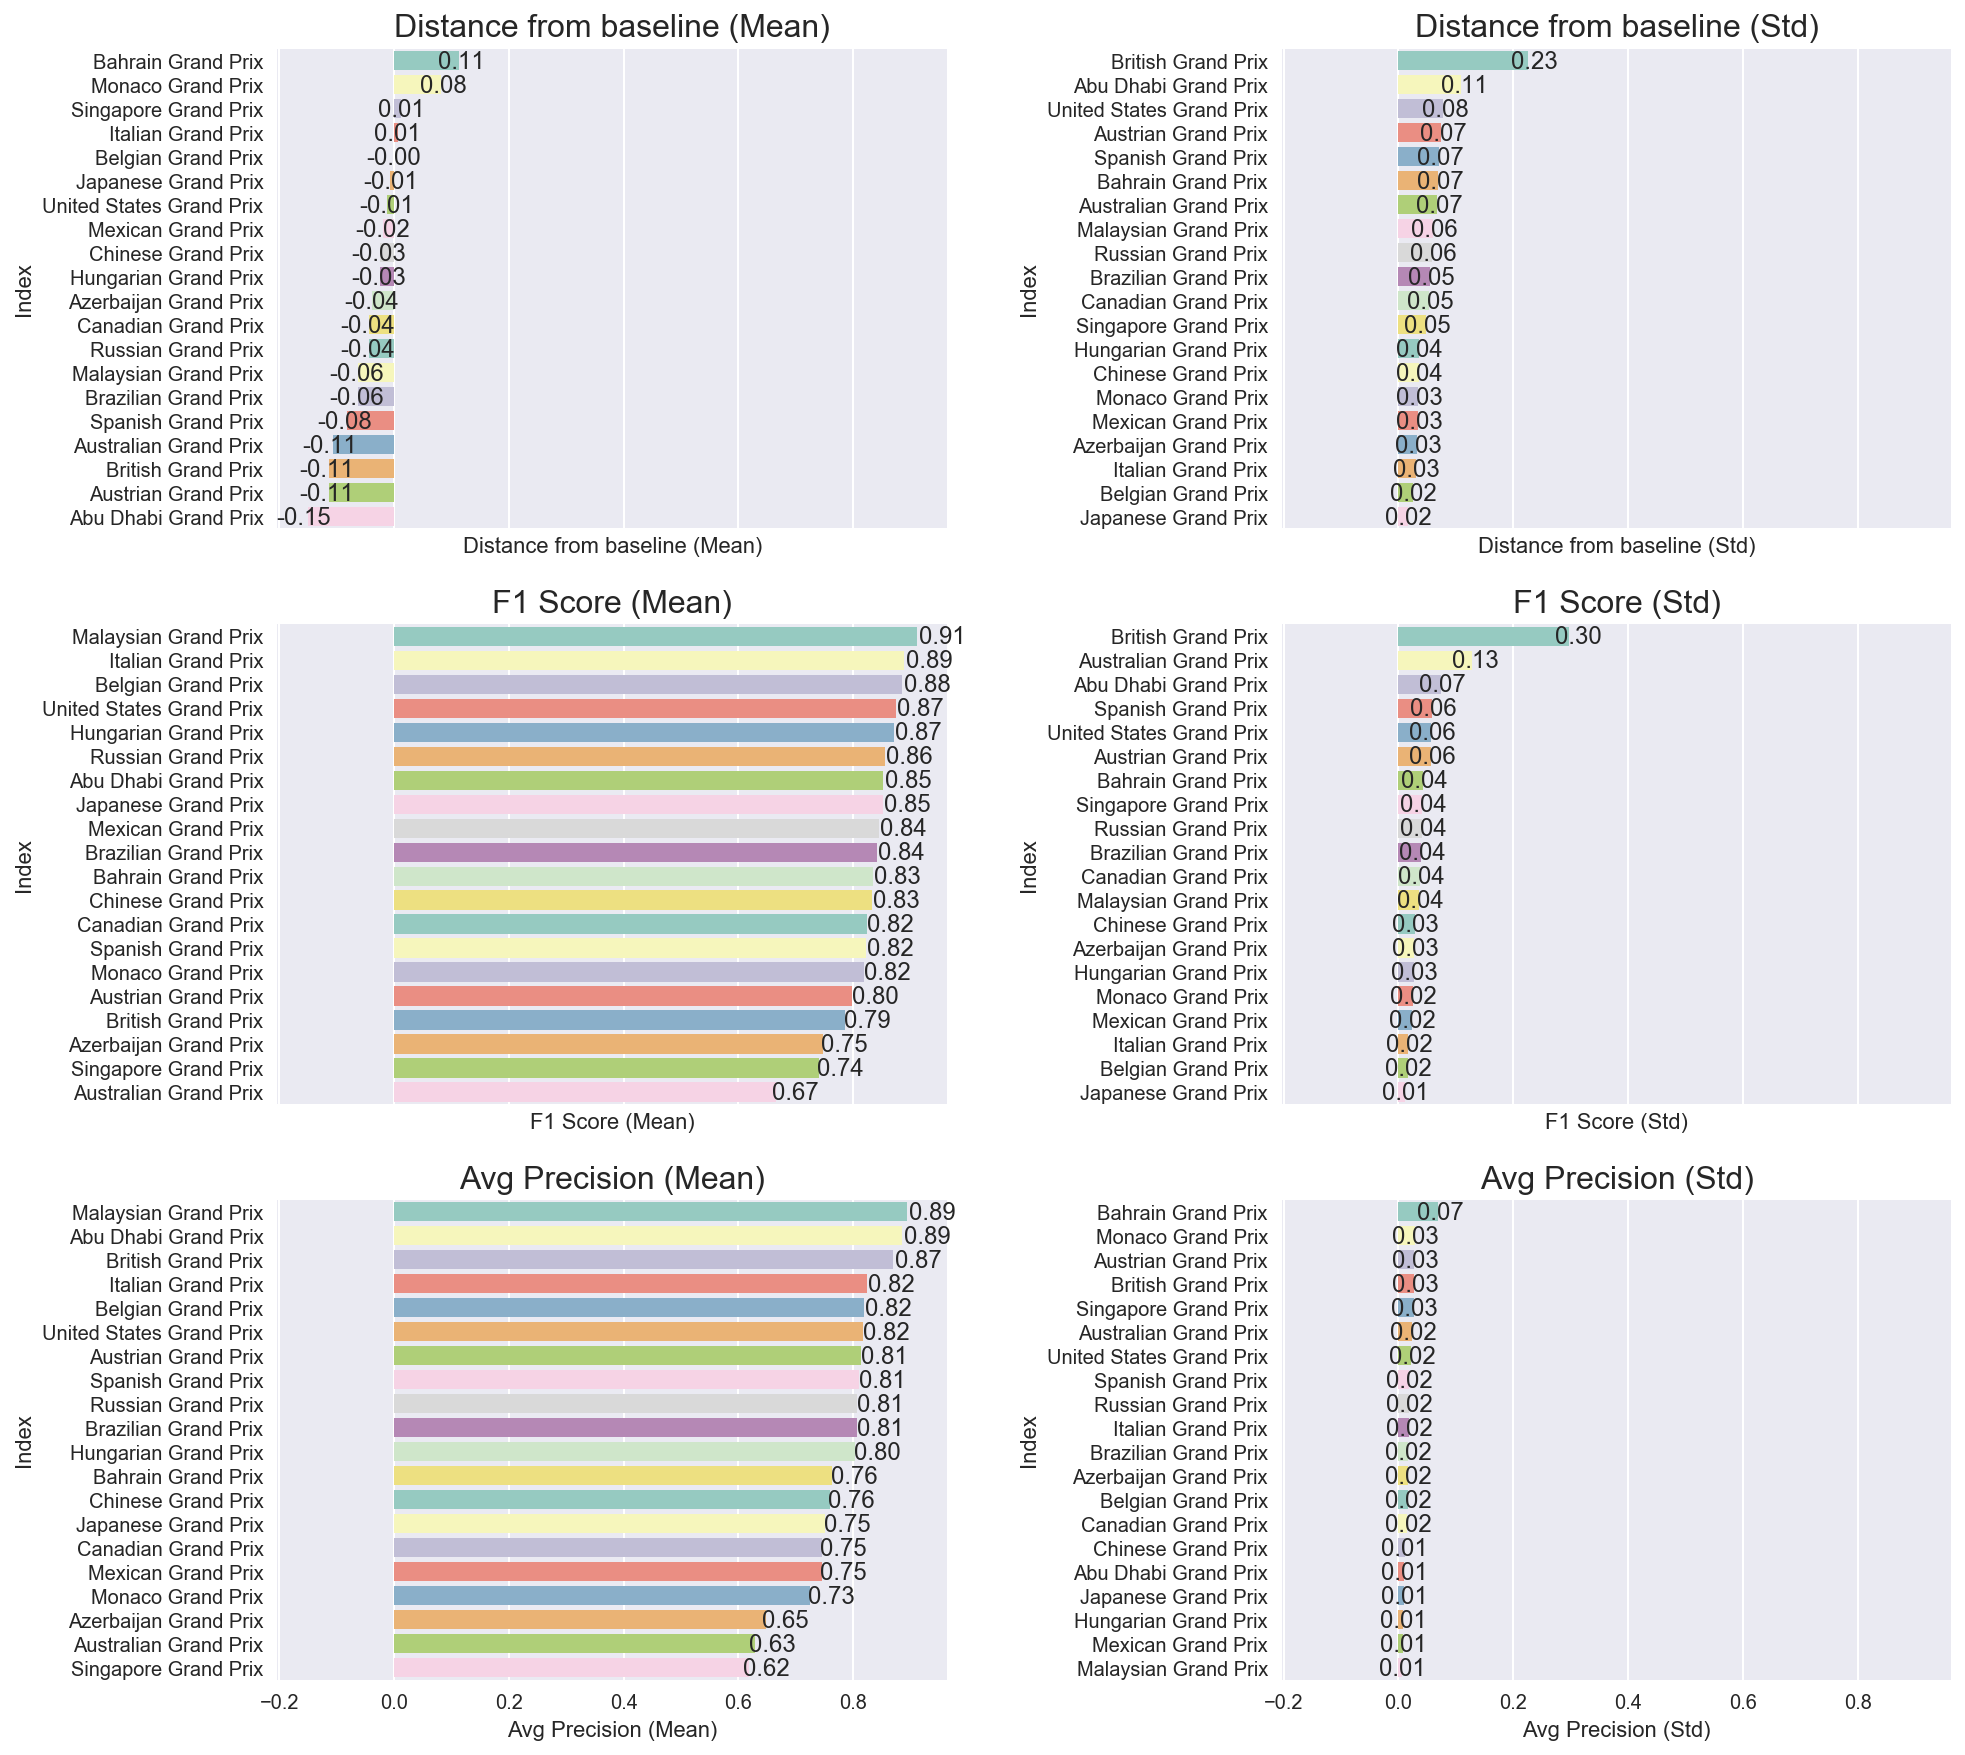

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [18]:
idx_best_model = plot_algo_results(best_model, grp_col="Index", metrics_list=metrics_list, sort_method='desc')

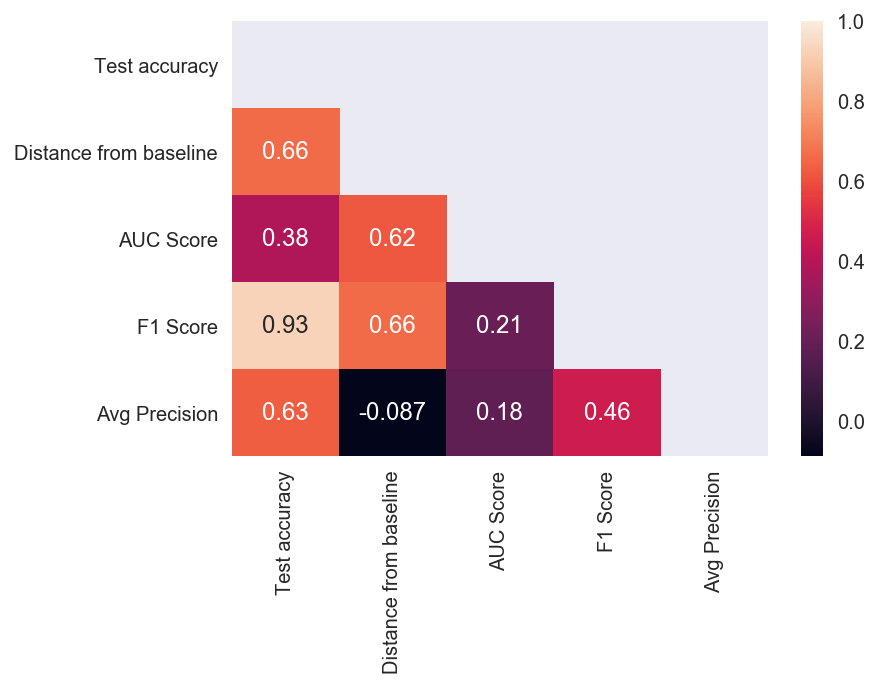

In [19]:
def gen_mask(df):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True         
    return mask

sns.heatmap(best_model.corr(), mask=gen_mask(best_model.corr()), annot=True)

### Feature importance of tree based classifiers

- Choose to plot for the best perfoming model only
- For the chosen model, plot for 3 selected races -  Australian Grand Prix, Monaco Grand Prix, Hungarian Grand Prix

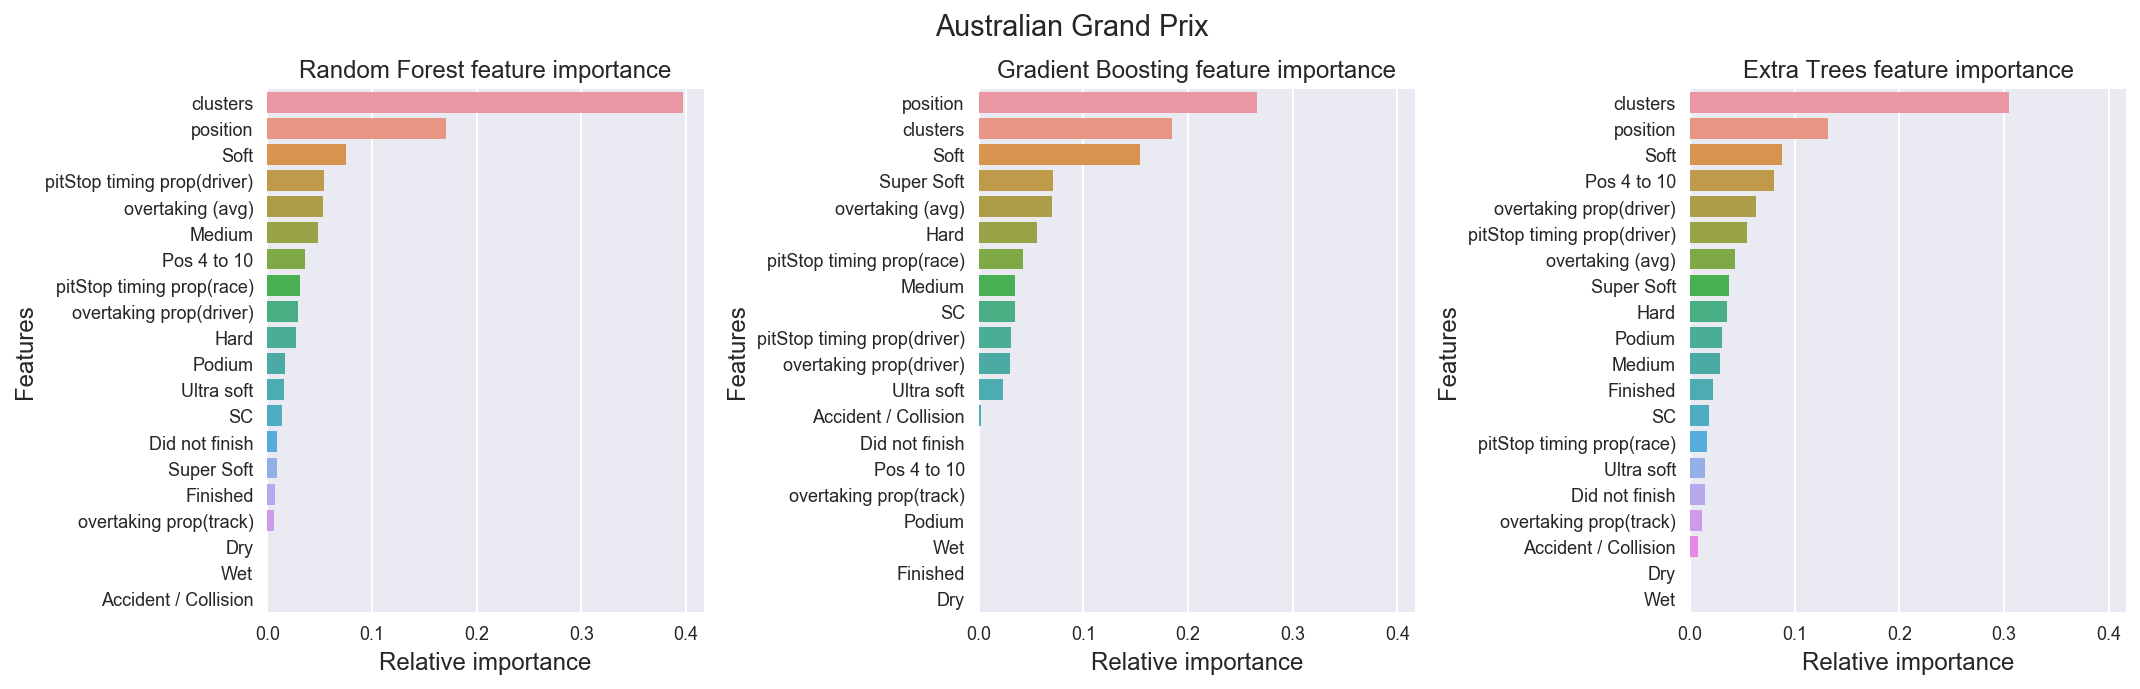

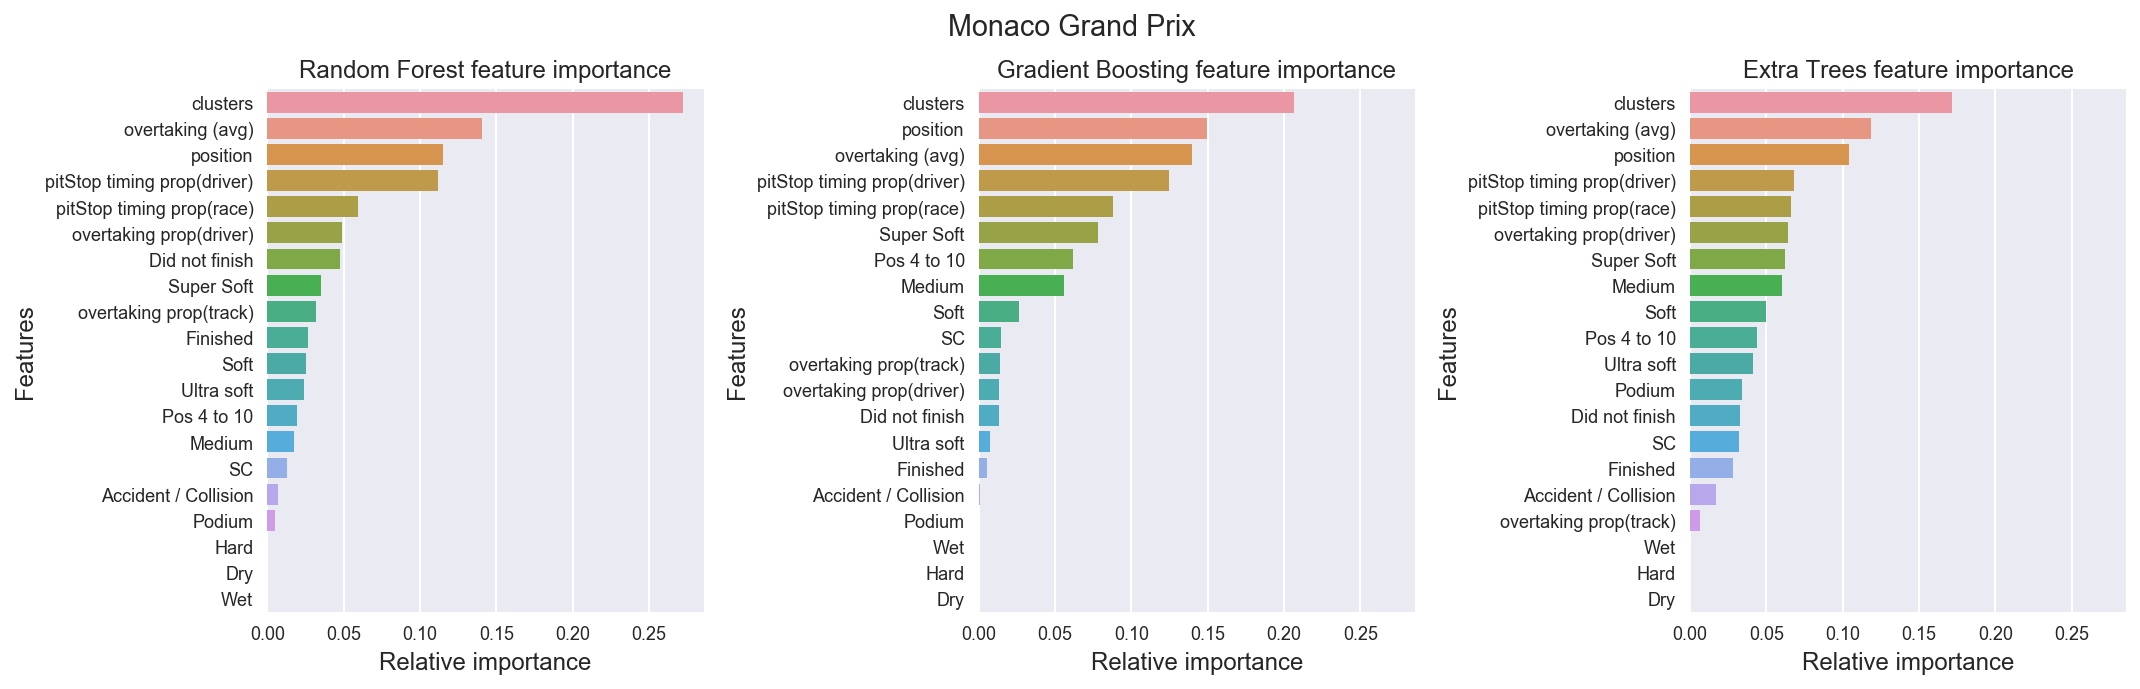

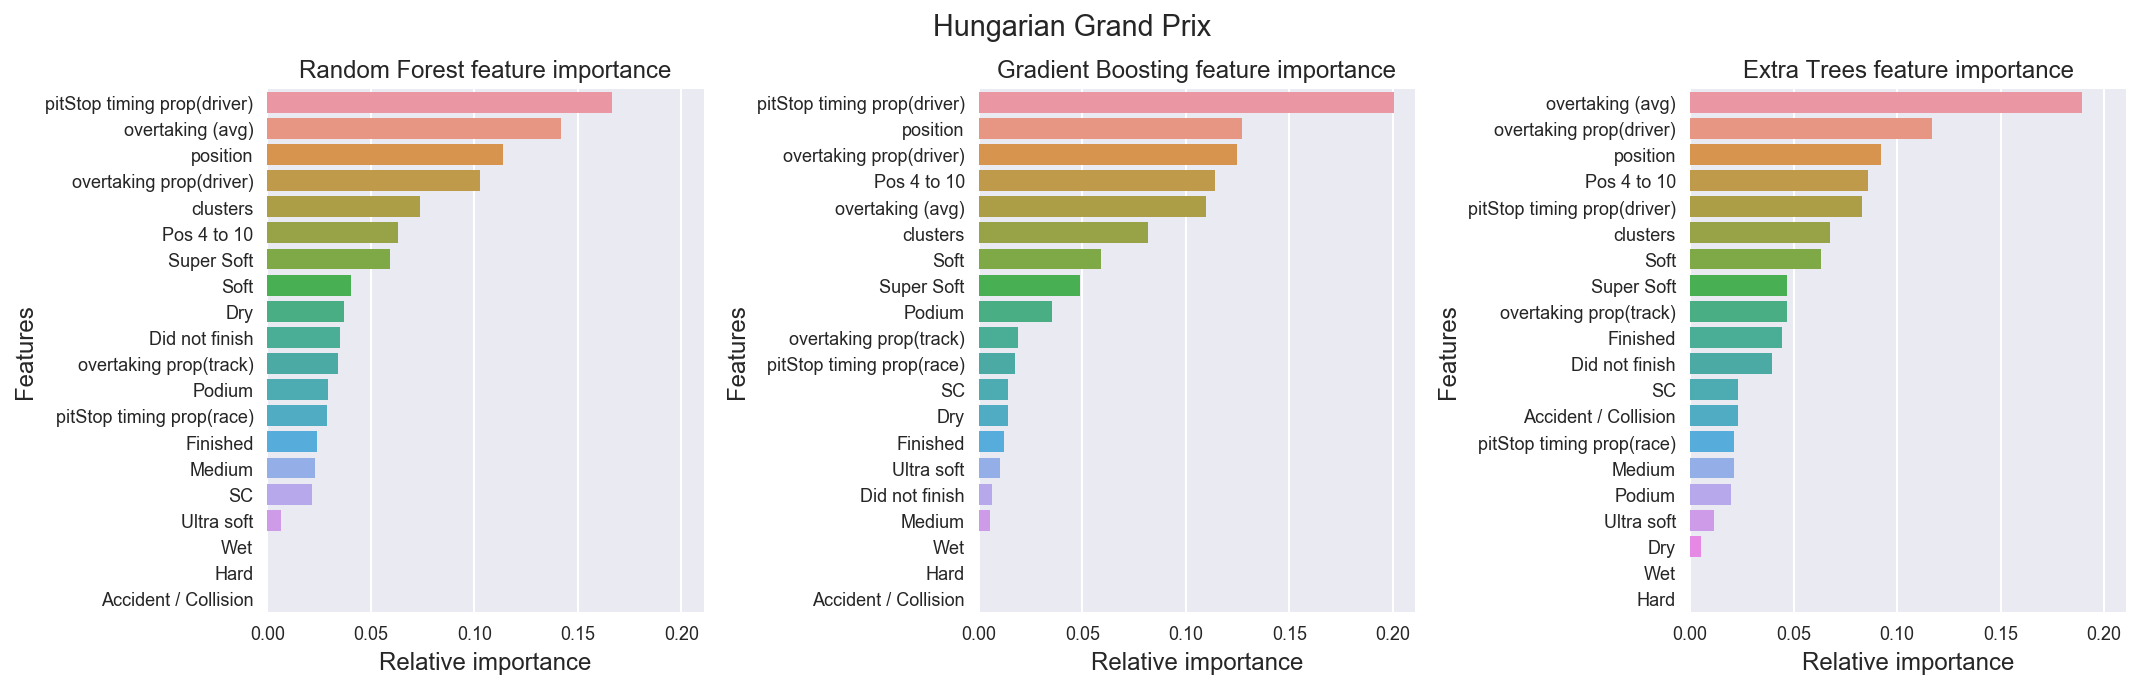

In [20]:
trees_clfs = [
    
    ['Random Forest', RandomForestClassifier(random_state=rs, class_weight=None)],
    ['Gradient Boosting', GradientBoostingClassifier(random_state=rs)],
    ['Extra Trees',  ExtraTreesClassifier(random_state=rs)],
]

races_to_plot = ['Australian Grand Prix', 'Monaco Grand Prix', 'Hungarian Grand Prix']
        
for idx,race in enumerate(races_to_plot):
    for m in trees_clfs:

        b = Build_train_test_set(True, dataset_1, test_1, race)
        train_set1, test_set1, Xs_train1, Xs_test1, Y_train1, Y_test1 = b.train_test_split(train_yr=[2016], test_yr=[2017], qty_races_tofilter=3)
        m[1].fit(Xs_train1, Y_train1)

    cols_f = np.setdiff1d(train_set1.columns, np.array(index_list + target_var_list))
    train_set1_plot = train_set1.loc[:, cols_f]

    nrows = 1
    ncols = 3
    fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex="all", figsize=(15,5), squeeze=False)
    nclassifier = 0
    for row in range(nrows):
        for col in range(ncols):
            name = trees_clfs[nclassifier][0]
            classifier = trees_clfs[nclassifier][1]
            indices = np.argsort(classifier.feature_importances_)[::-1][:40]
            g = sns.barplot(y=train_set1_plot.columns[indices][:40], x = classifier.feature_importances_[indices][:40] ,
                            orient='h',ax=axes[row][col])
            g.set_xlabel("Relative importance",fontsize=12)
            g.set_ylabel("Features",fontsize=12)
            g.tick_params(labelsize=9)
            g.set_title(name + " feature importance")
            fig.suptitle(race)
            nclassifier += 1
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])

### If ensembling is not to be performed next, Model 2_5 with Random Forest as the classifier perfomed the best in terms of  highest AUC ROC score aggregated across all races in a season. 

### If ensembling is to be performed next in a bid to improve prediction results, use Model 2_5 with Random Forest as the base for rest of models to be combined with.  How to decide which other models to use in stacking?

#### Approach 1: 
This is based upon the concept that ensemble learning works best if models to stack are not highly correlated with each other.
- 1) Fix a metric to assess stacking: AUC Score
- 2) Find the performance of individual models (Done)
- 3) Choose the best performing sub-model as the initial selection. 
- 4) Iteratively choose all the sub-models which are not highly correlated with this 'best' sub-model. Arrange the columns of dataframe of test prediction probabilities from lowest to highest correlation. (Set a correlation limit of less than 0.9 and more than 0.4.
- 5) Having chosen a sequence of models, iterate through each combination (add a sub-model with each iteration)and check their performance.
- 6) Choose the combination which gives the highest AUC score with cross-validation of training set.
- Note: Each race will have their own optimal sequence of models to stack. 

#### Approach 2:
- Instead of selecting models based on correlation, select the top 10 'best' performing sub-models based on AUC Score

## 2) Ensemble: Second-Level Predictions from the First-level Output 

In [21]:
best_submodel = 'Gradient Boosting_statusId_1_4'

#### Ensemble stacking by finding optimal sequence of sub-models to stack for each race

In [22]:
ensemble_results_all, results_ens, pred_ens, proba_ens = \
    CR.ensemble_stacking(actual=False, report=submodel_report[0:21], train_yr=[2016], test_yr=[2017],
                         Pa_train_all=Pa_train_all_new, Pa_test_all=Pa_test_all_new,
                         meta_learner = meta_learner_GB, option=1)

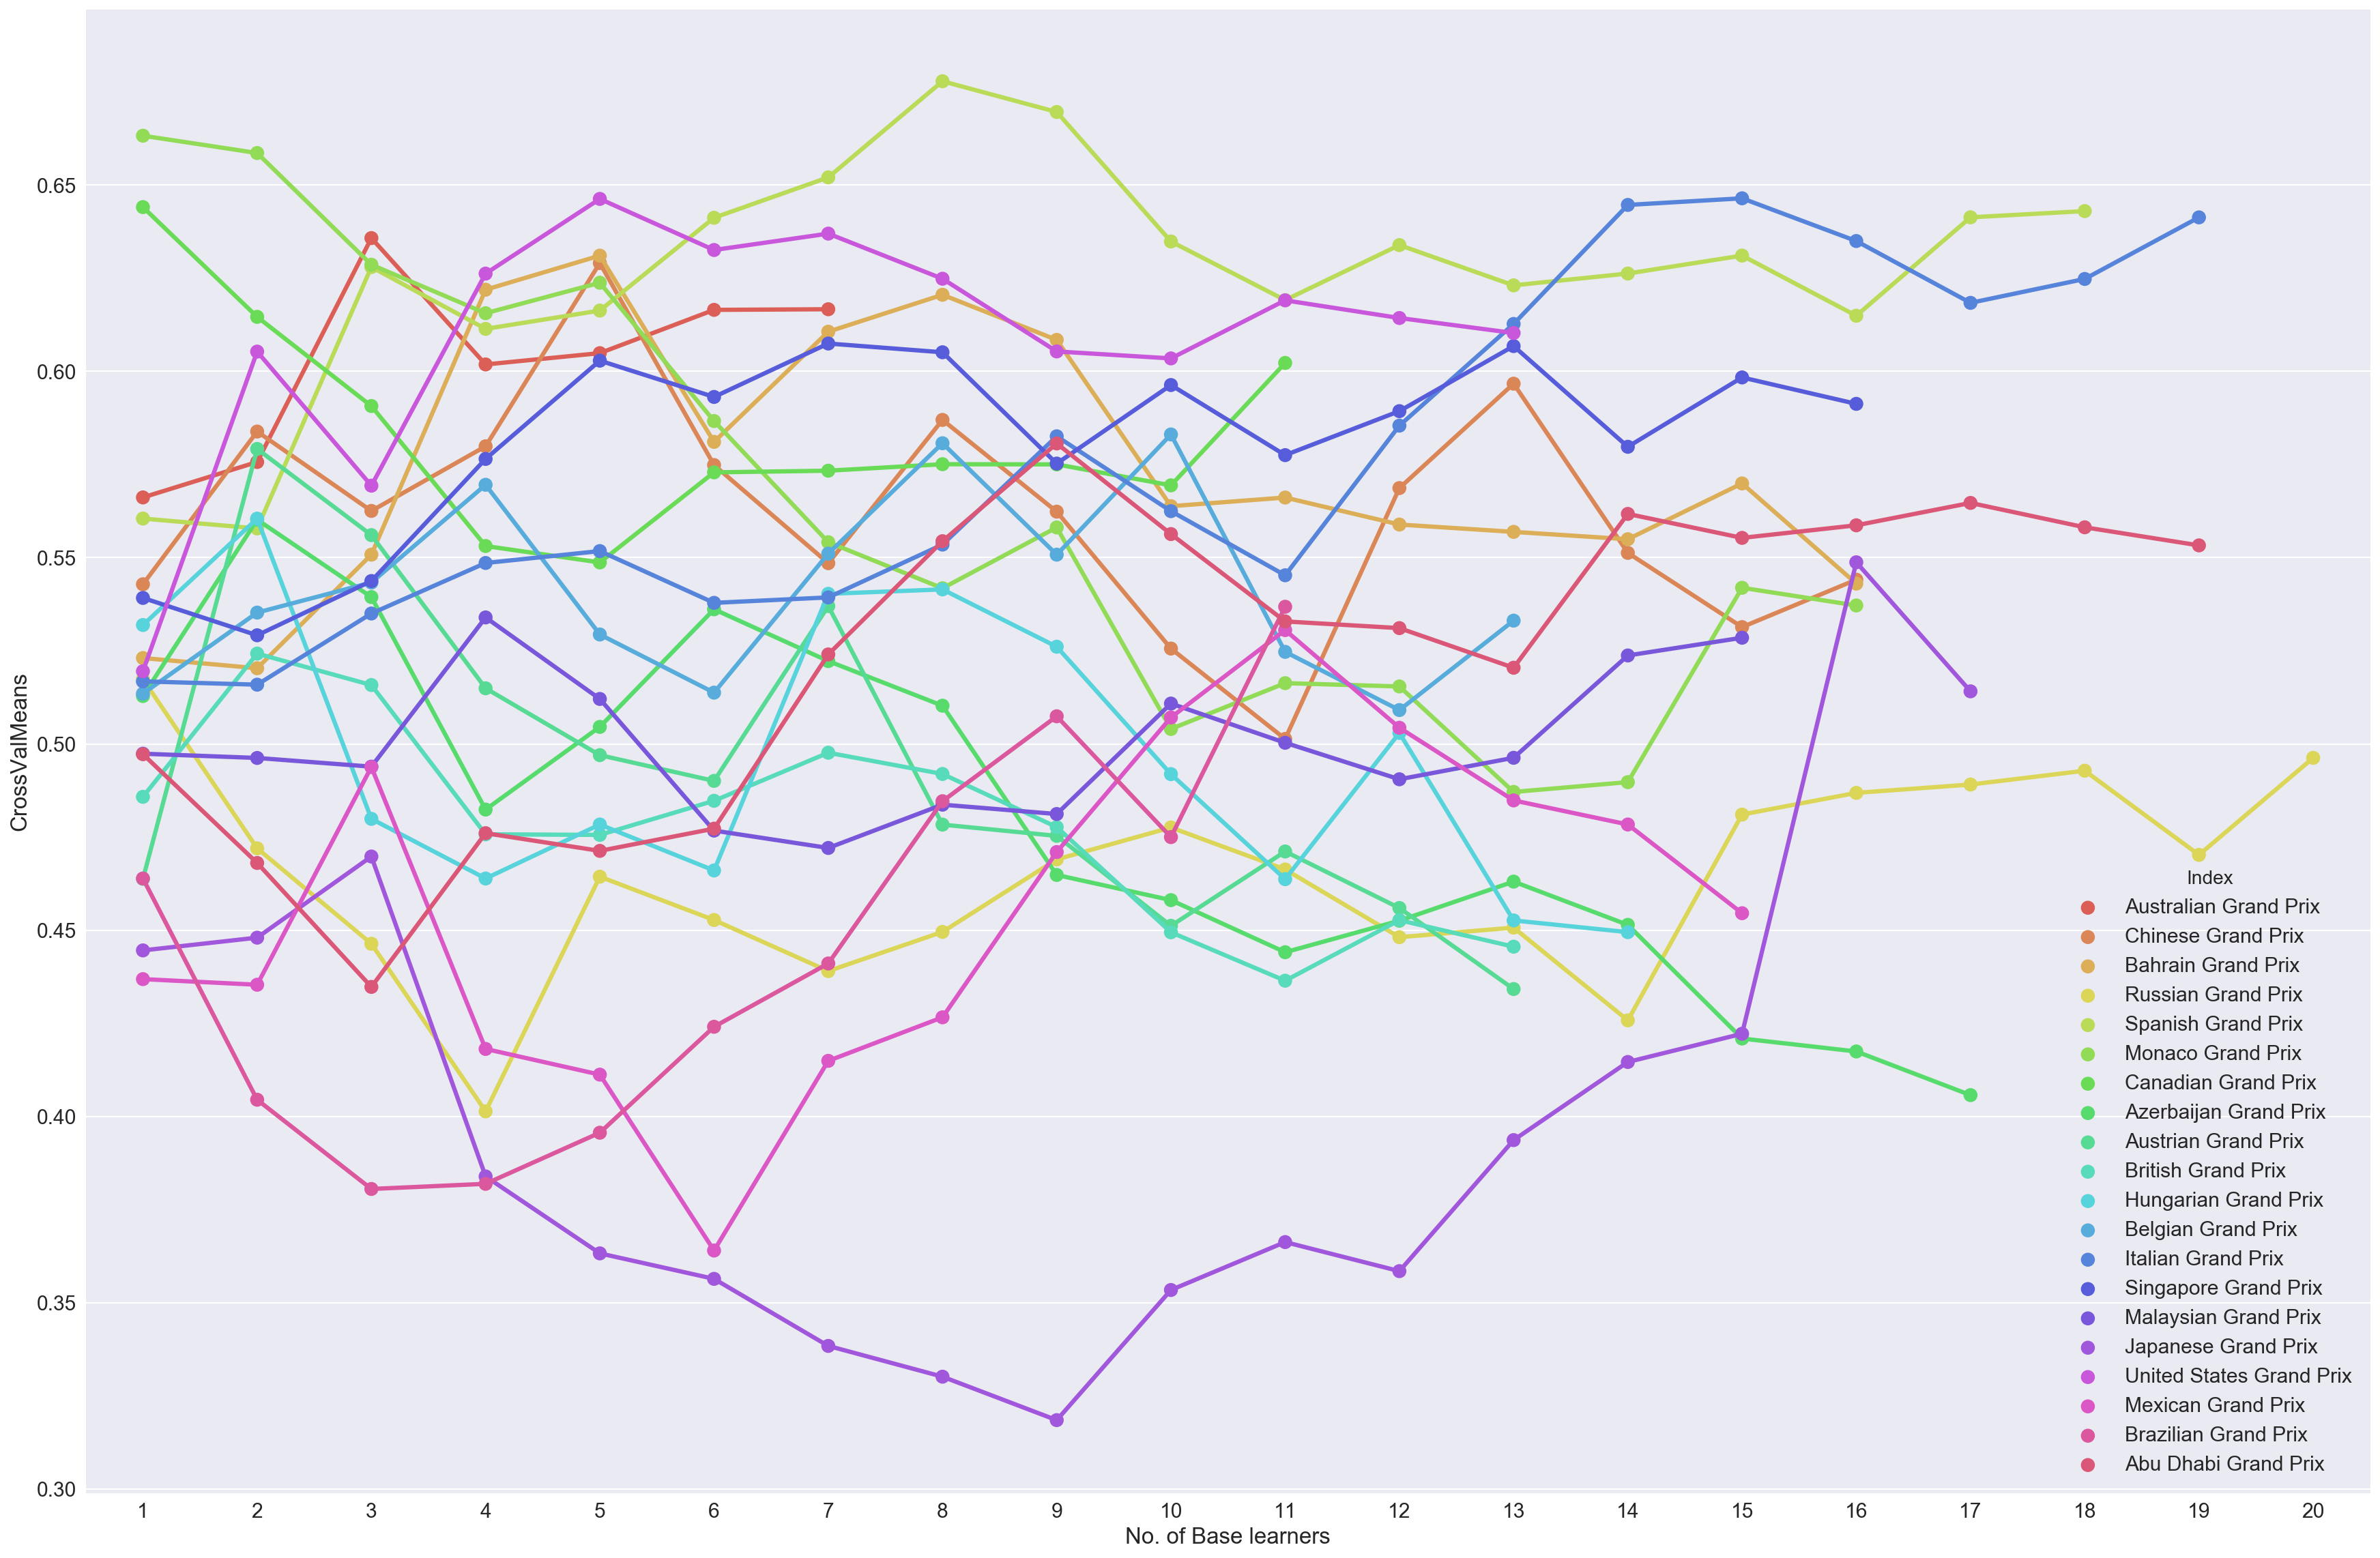

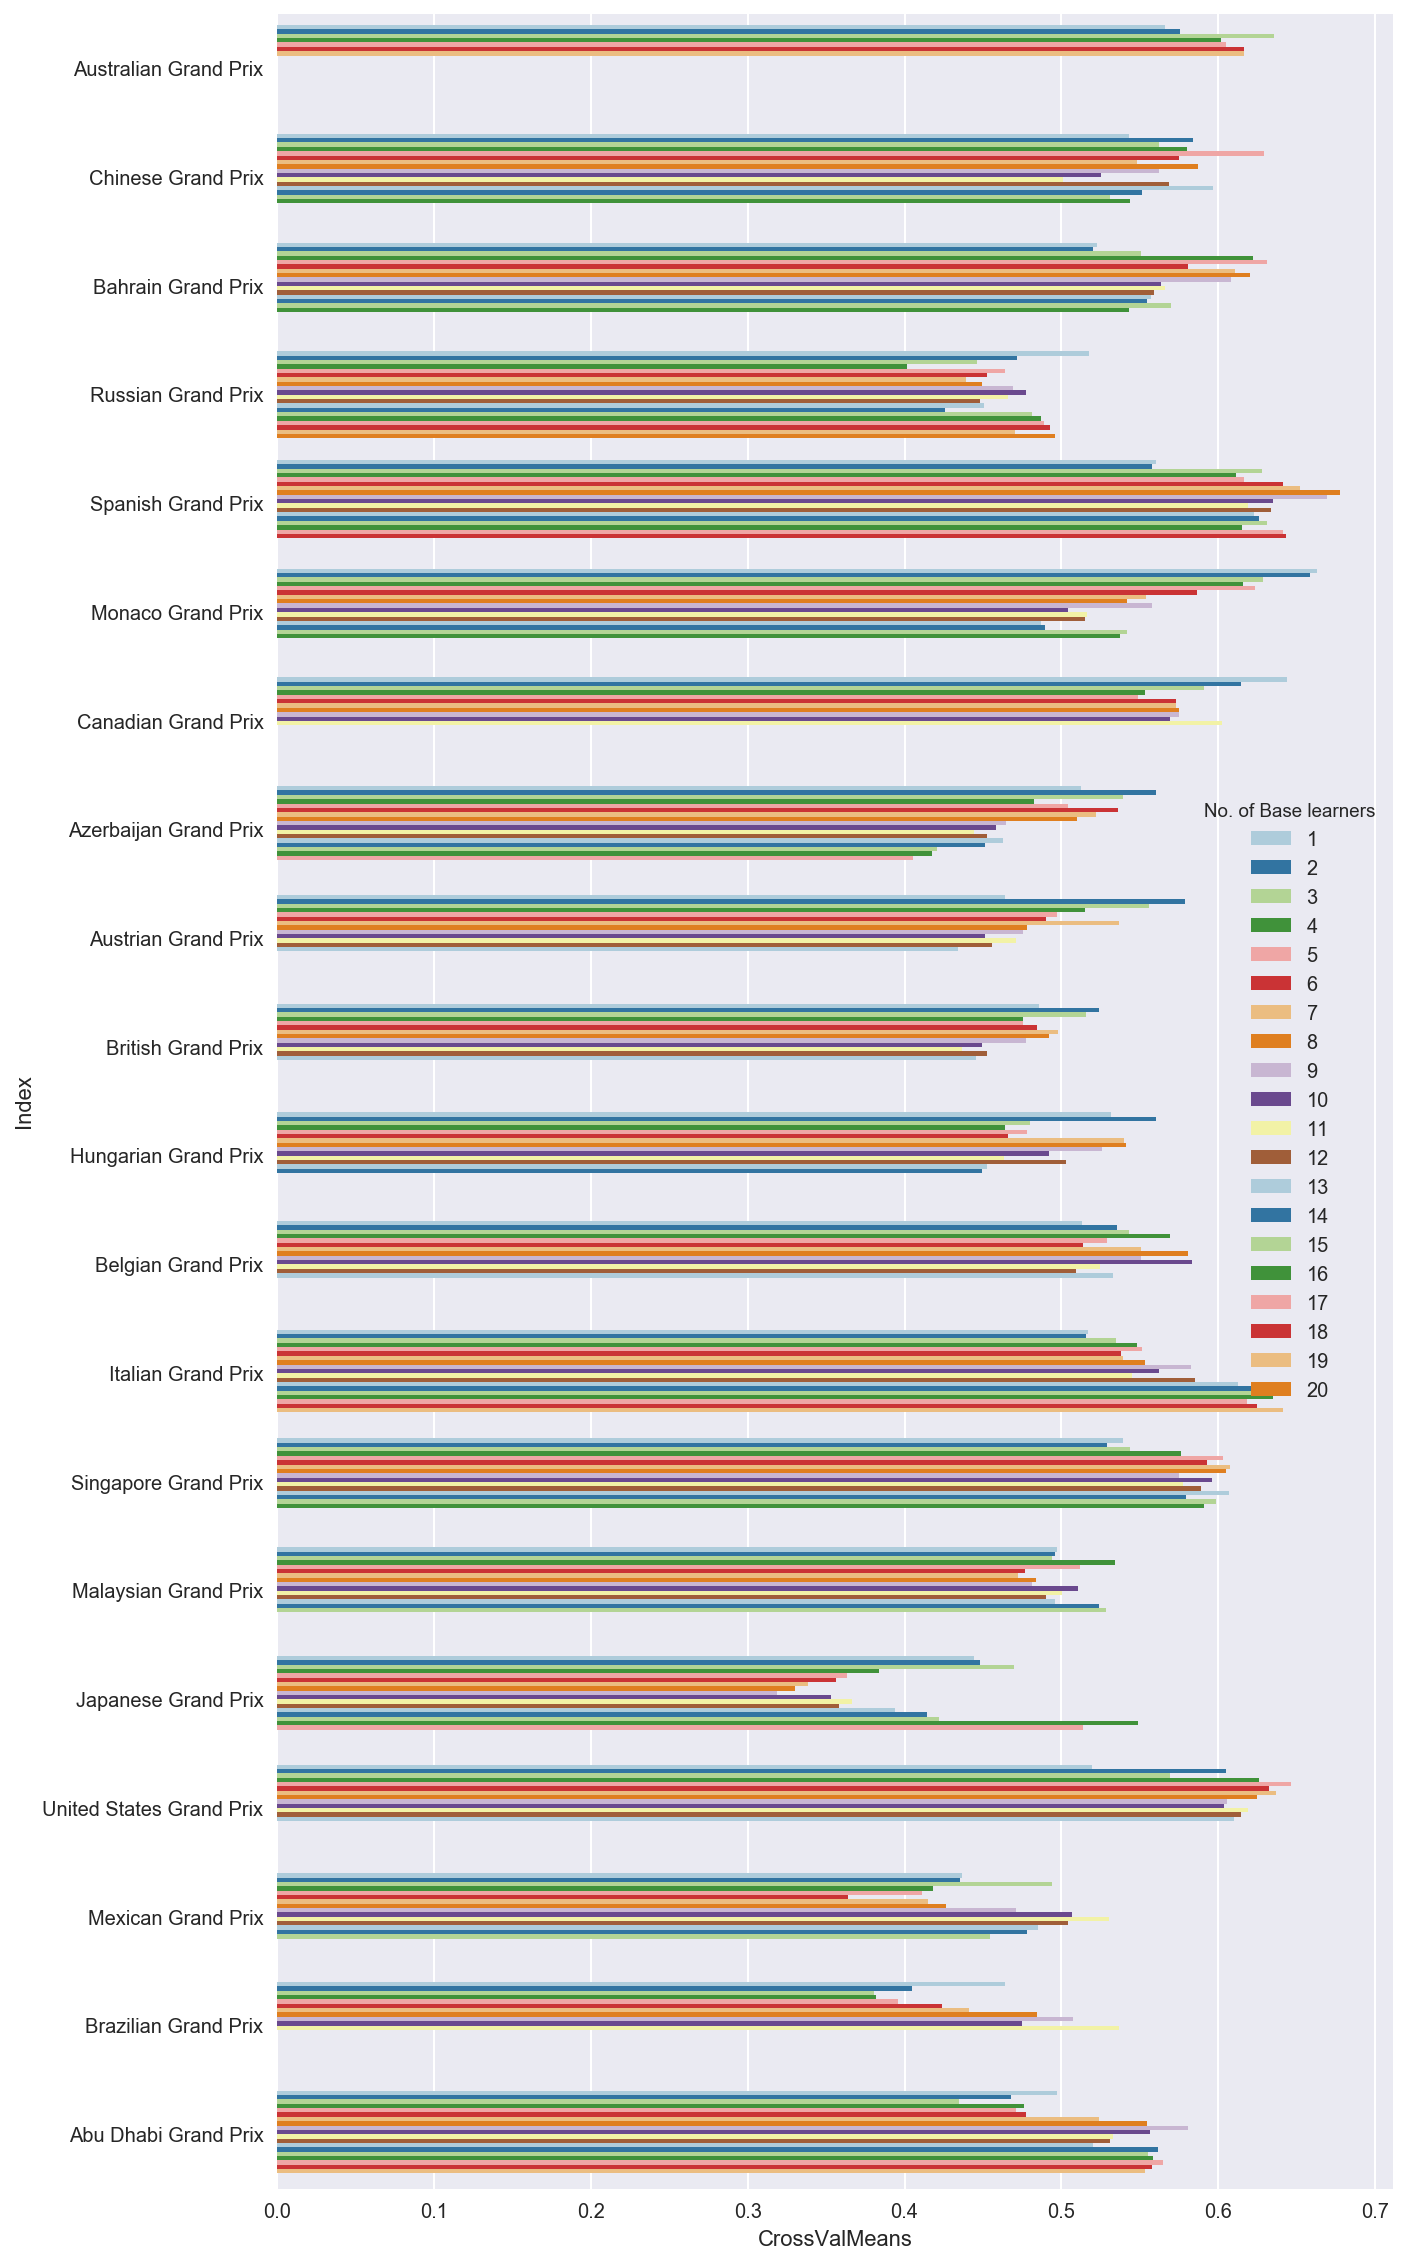

In [23]:
plot_ensemble_seq(ensemble_results_all)

#### Ensemble stacking by stacking a few 'best' performing sub-models based on AUC score (I set a criteria of AUC score > 0.55, which only 2 sub-models qualify)

In [56]:
results_2, pred_2, proba_2 = \
    CR.ensemble_stacking(report=submodel_report[0:2], train_yr=[2016], test_yr=[2017],
                         Pa_train_all=Pa_train_all_new, Pa_test_all=Pa_test_all_new,
                         meta_learner = meta_learner_GB, option=2)

## Visualization of final prediction results

#### 1) Best sub-model

In [25]:
Pa_A = Pa_test_all_new[index_list+target_var_list+[best_submodel]]

In [26]:
labels = ['DNF', 'FIN']
conf_matrix_A, driver_matrix_A = conf_mat(Pa_A, idx=labels, col_labels=['DNF_A', 'FIN_A'])
conf_matrix_A_r, driver_matrix_A_r = conf_mat_each_race(Pa_A, labels, '_A')

In [27]:
conf_matrix_A

,DNF_A,FIN_A
DNF,23.0,72.0
FIN,35.0,270.0


In [50]:
conf_matrix_A_r

DNF_A  FIN_A
race                             status              
(2017, Abu Dhabi Grand Prix)     DNF       0.0    2.0
                                 FIN       2.0   16.0
(2017, Australian Grand Prix)    DNF       0.0    7.0
                                 FIN       0.0   13.0
(2017, Austrian Grand Prix)      DNF       2.0    2.0
                                 FIN       3.0   13.0
(2017, Azerbaijan Grand Prix)    DNF       3.0    4.0
                                 FIN       4.0    9.0
(2017, Bahrain Grand Prix)       DNF       3.0    4.0
                                 FIN       0.0   13.0
(2017, Belgian Grand Prix)       DNF       1.0    3.0
                                 FIN       3.0   13.0
(2017, Brazilian Grand Prix)     DNF       0.0    4.0
                                 FIN       0.0   16.0
(2017, British Grand Prix)       DNF       1.0    2.0
                                 FIN       5.0   12.0
(2017, Canadian Grand Prix)      DNF       0.0    5.0
                                 FIN       1.0   14.0
(2017, Chinese Grand Prix)       DNF       2.0    3.0
                                 FIN       1.0   14.0
(2017, Hungarian Grand Prix)     DNF       0.0    4.0
                                 FIN       0.0   16.0
(2017, Italian Grand Prix)       DNF       1.0    3.0
                                 FIN       2.0   14.0
(2017, Japanese Grand Prix)      DNF       0.0    5.0
                                 FIN       1.0   14.0
(2017, Malaysian Grand Prix)     DNF       0.0    2.0
                                 FIN       2.0   16.0
(2017, Mexican Grand Prix)       DNF       0.0    5.0
                                 FIN       1.0   14.0
(2017, Monaco Grand Prix)        DNF       4.0    3.0
                                 FIN       2.0   11.0
(2017, Russian Grand Prix)       DNF       1.0    3.0
                                 FIN       4.0   12.0
(2017, Singapore Grand Prix)     DNF       2.0    6.0
                                 FIN       0.0   12.0
(2017, Spanish Grand Prix)       DNF       2.0    2.0
                                 FIN       3.0   13.0
(2017, United States Grand Prix) DNF       1.0    3.0
                                 FIN       1.0   15.0

In [51]:
driver_matrix_A_r

DNF_A  \
race                             status                                                      
(2017, Abu Dhabi Grand Prix)     DNF                                                     0   
                                 FIN                                    [wehrlein, stroll]   
(2017, Australian Grand Prix)    DNF                                                     0   
                                 FIN                                                     0   
(2017, Austrian Grand Prix)      DNF                                  [verstappen, alonso]   
                                 FIN                         [ricciardo, raikkonen, kvyat]   
(2017, Azerbaijan Grand Prix)    DNF                       [verstappen, hulkenberg, kvyat]   
                                 FIN                [ricciardo, bottas, vandoorne, stroll]   
(2017, Bahrain Grand Prix)       DNF                           [alonso, vandoorne, stroll]   
                                 FIN                                                     0   
(2017, Belgian Grand Prix)       DNF                                            [wehrlein]   
                                 FIN                          [ericsson, sainz, magnussen]   
(2017, Brazilian Grand Prix)     DNF                                                     0   
                                 FIN                                                     0   
(2017, British Grand Prix)       DNF                                               [sainz]   
                                 FIN     [verstappen, grosjean, ericsson, kvyat, vandoo...   
(2017, Canadian Grand Prix)      DNF                                                     0   
                                 FIN                                           [vandoorne]   
(2017, Chinese Grand Prix)       DNF                                  [stroll, giovinazzi]   
                                 FIN                                          [verstappen]   
(2017, Hungarian Grand Prix)     DNF                                                     0   
                                 FIN                                                     0   
(2017, Italian Grand Prix)       DNF                                              [palmer]   
                                 FIN                                     [perez, wehrlein]   
(2017, Japanese Grand Prix)      DNF                                                     0   
                                 FIN                                              [alonso]   
(2017, Malaysian Grand Prix)     DNF                                                     0   
                                 FIN                                 [ericsson, magnussen]   
(2017, Mexican Grand Prix)       DNF                                                     0   
                                 FIN                                            [wehrlein]   
(2017, Monaco Grand Prix)        DNF                  [ericsson, kvyat, vandoorne, stroll]   
                                 FIN                                  [verstappen, palmer]   
(2017, Russian Grand Prix)       DNF                                            [grosjean]   
                                 FIN             [verstappen, ericsson, vandoorne, stroll]   
(2017, Singapore Grand Prix)     DNF                                  [hulkenberg, alonso]   
                                 FIN                                                     0   
(2017, Spanish Grand Prix)       DNF                                [raikkonen, vandoorne]   
                                 FIN                        [hulkenberg, grosjean, stroll]   
(2017, United States Grand Prix) DNF                                          [hulkenberg]   
                                 FIN                                            [ericsson]   

                                                                                     FIN_A  
race                             status    

#### 2) Ensemble stacking by finding optimal sequence of sub-models to stack for each race

In [28]:
conf_matrix_B, driver_matrix_B = conf_mat(proba_ens, idx=labels, col_labels=['DNF_B', 'FIN_B'])

In [29]:
conf_matrix_B

,DNF_B,FIN_B
DNF,8.0,87.0
FIN,29.0,276.0


#### 3) Ensemble stacking by stacking a few 'best' performing sub-models based on AUC score (I set a criteria of AUC score > 0.55, which only 2 sub-models qualify)

In [57]:
conf_matrix_C, driver_matrix_C = conf_mat(proba_2, idx=labels, col_labels=['DNF_C', 'FIN_C'])

In [58]:
conf_matrix_C

,DNF_C,FIN_C
DNF,10.0,85.0
FIN,29.0,276.0


### Conclusion
- Model 1_4 (ie. Dataset 1 with 4 previous races before the currnt race to be tested included in training set) with Gradient Boosting classifier is the best model based on highest AUC score.
- With this chosen sub-model, it correctly predicted 23 drivers who did not finish a race, but with every driver which DNF it correctly predicted, almost 2 drivers where incorrectly predicted to not have finished. 
- 270 drivers were correctly predicted to have finished the race.
- Models with ensemble stacking of sub-models performed worse than predicting using the best sub-model (Model 1_4 with Gradient Boosting).